In [1]:
# ディープラーニングモデルの作成

import numpy as np

# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

import pandas as pd

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [8]:
# データのロード
import pandas_datareader.data as pdr
import datetime


start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 12, 31)
 
pd_data = pdr.DataReader(['VTI','VEA','VWO','AGG','GLD','IYR'], 'yahoo', start, end)
data_close = pd_data['Close']
 
data_close.head() 

Symbols,VTI,VEA,VWO,AGG,GLD,IYR
Date,,,,,,
2019-12-31,163.619995,44.060001,44.470001,112.370003,142.899994,93.080002
2020-01-02,164.979996,44.419998,45.529999,112.680000,143.949997,92.050003
2020-01-03,163.929993,43.880001,44.720001,113.010002,145.860001,92.709999
2020-01-06,164.490005,44.029999,44.639999,112.919998,147.389999,92.790001
2020-01-07,164.100006,43.959999,44.619999,112.800003,147.970001,91.849998


In [9]:
model = Model()
alc = model.get_allocations(data_close)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0272
Epoch 2/20
1/1 [==============================] - 0s 118ms/step - loss: -0.0278
Epoch 3/20
1/1 [==============================] - 0s 113ms/step - loss: -0.0285
Epoch 4/20
1/1 [==============================] - 0s 119ms/step - loss: -0.0292
Epoch 5/20
1/1 [==============================] - 0s 108ms/step - loss: -0.0300
Epoch 6/20
1/1 [==============================] - 0s 105ms/step - loss: -0.0307
Epoch 7/20
1/1 [==============================] - 0s 102ms/step - loss: -0.0314
Epoch 8/20
1/1 [==============================] - 0s 102ms/step - loss: -0.0320
Epoch 9/20
1/1 [==============================] - 0s 102ms/step - loss: -0.0324
Epoch 10/20
1/1 [==============================] - 0s 137ms/step - loss: -0.0329
Epoch 11/20
1/1 [==============================] - 0s 114ms/step - loss: -0.0334
Epoch 12/20
1/1 [==============================] - 0s 108ms/step - loss: -0.0340
Epoch 13/20
1/1 [=======================

([<matplotlib.patches.Wedge at 0x7fe0181c0c90>,
 [Text(0.8257687317870086, 0.7267090212752801, 'VTI'),
  Text(-0.622022249694513, 0.9072421511840029, 'VEA'),
  Text(-1.0199875676878036, -0.4118559963899016, 'VWO'),
  Text(-0.24998783454471932, -1.0712171033827094, 'AGG'),
  Text(0.6924415879308387, -0.8547073459985113, 'GLD'),
  Text(1.0866084481168101, -0.1711200762072584, 'IYR')])

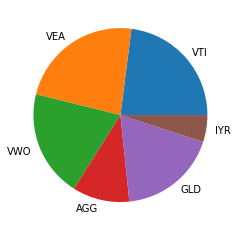

In [13]:
import matplotlib.pyplot as plt

plt.pie(alc, labels=data_close.columns.tolist())

In [12]:
c = data_close.columns.tolist()